<a href="https://www.kaggle.com/rsizem2/kaggle-learn-reference-feature-engineering?scriptVersionId=84631932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Engineering

This notebook is an attempt to summarize the feature engineering techniques covered in the [Kaggle Learn](https://www.kaggle.com/learn/feature-engineering) course (the notes, the exercises and the [bonus notebook](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices)) into one notebook for easier reference. We conclude with a sample competition submission to the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course).

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12
MAX_TREES = 2000
EARLY_STOP = 50
NUM_TRIALS = 100
SUBMIT = True

In [2]:
# Essentials
import os
import warnings
import numpy as np
import pandas as pd
import time
from collections import defaultdict

# Models
from sklearn.base import clone
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Model Evaluation
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error

# Preprocessing
from functools import partial, reduce
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder

# Feature Engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder

# Hyperparameter Tuning
import optuna
from optuna.visualization import plot_param_importances, plot_parallel_coordinate
from optuna.pruners import PercentilePruner

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# Load the training data
train = pd.read_csv("../input/home-data-for-ml-course/train.csv")
test = pd.read_csv("../input/home-data-for-ml-course/test.csv")
submission = pd.read_csv("../input/home-data-for-ml-course/sample_submission.csv")

# Remove rows with missing target
train.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Columns of interest
features = [x for x in train.columns if x not in ['SalePrice','Id']]
categorical = [x for x in features if train[x].dtype == "object"]
numerical = [x for x in features if  train[x].dtype in ['int64', 'float64']]

# Bin target for stratified cross-validation
binner = KBinsDiscretizer(n_bins = 45, encode = 'ordinal', strategy = 'quantile')
y_bins = binner.fit_transform(pd.DataFrame(data=train['SalePrice']))

# Preliminaries: Preprocessing 

This section involves preprocessing our data prior to feature engineering, in particular, dealing with missing values and encoding categorical variables. This content is covered in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course, and is the subject of my [previous notebook](https://www.kaggle.com/rsizem2/kaggle-learn-reference-intermediate-ml). In this section we will do the following:

1. Clean data by fixing typos and erroneous values
2. Impute numerical data with the column mean
3. Ordinally encode the *ordinal* variables
4. Use a mix of ordinal and one-hot encoding for the *nominal* variables

## 1. Data Cleaning

We fix some typos and bad values in our raw data.

In [4]:
def data_cleaning(input_df):
    df = input_df.copy()
    
    # Data cleaning: fix typos and bad values
    df['MSZoning'] =  df['MSZoning'].replace({'C (all)': 'C'})
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn":"BrkComm","Wd Shng": "WdShing"})
    df['Neighborhood'] = df['Neighborhood'].replace({'NAmes':'Names'})
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    #df["MSClass"] = df['MSZoning'].map({'A': 'A','C': 'C',"FV": 'R','I': 'I',"RH": 'R',"RL": 'R',"RP": 'R',"RM": 'R', np.nan:np.nan})
    
    return df

## 2. Imputation

We replace numerical NA values with the column mean and categorical NAs with a placeholder value.

In [5]:
# Transformations that depend only on the input data (no fear of leakage)
def imputation(X_train, X_valid, X_test = None, num_strategy = 'mean', cat_strategy = 'constant'):

    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. impute numerical data
    assert num_strategy in ['median','mean']
    columns = [col for col in X_train.columns if X_train[col].dtype != "object"]
    num_imputer = SimpleImputer(strategy = num_strategy)
    X_train[columns] = num_imputer.fit_transform(X_train[columns])
    X_valid[columns] = num_imputer.transform(X_valid[columns])
    if X_test is not None:
        X_test[columns] = num_imputer.transform(X_test[columns])
    
    # 2. impute categorical data
    assert cat_strategy in ['constant','most_frequent']
    cat_imputer = SimpleImputer(strategy = cat_strategy, fill_value = 'None')
    columns = [col for col in X_train.columns if X_train[col].dtype == "object"]
    X_train[columns] = cat_imputer.fit_transform(X_train[columns])
    X_valid[columns] = cat_imputer.transform(X_valid[columns])
    if X_test is not None:
        X_test[columns] = cat_imputer.transform(X_test[columns])
        
    return X_train, X_valid, X_test

## 3. Encoding Ordinal Variables

A few of our variables are based on ratings (e.g. poor, fair, good) of various qualities of the property. We hard code this ordering:

In [6]:
def ordinal_encoding(X_train, X_valid, X_test = None):
    
    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. Encode 1-10 ratings
    cols = ["OverallQual","OverallCond"]
    cols = [x for x in cols if x in X_train.columns]
    ratings = {float(a):b for b,a in enumerate(range(1,11))}
    mapping = [{'col':x, 'mapping': ratings} for x in cols]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
    
    # 2. Encode Poor, Fair, Avg, Good, Ex ratings
    cols = ["ExterQual","ExterCond","BsmtQual","BsmtCond","HeatingQC", "KitchenQual","FireplaceQu","GarageQual","GarageCond",'PoolQC']
    cols = [x for x in cols if x in X_train.columns]
    ratings = {"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4}
    mapping = [{'col':x, 'mapping': ratings} for x in cols]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
    
    # 3. Encode remaining ordinal data
    cols = ["LotShape","LandSlope","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "Functional","GarageFinish","PavedDrive","Utilities","CentralAir","Electrical",
    "Fence"]
    cols = [x for x in cols if x in X_train.columns]
    mapping = [{'col':"LotShape",
                'mapping': {"Reg":0, "IR1":1, "IR2":2, "IR3":3}},
               {'col':"LandSlope",
                'mapping': {"Sev":0, "Mod":1, "Gtl":2}},
               {'col':"BsmtExposure",
                'mapping': {"No":0, "Mn":1, "Av":2, "Gd":3}},
               {'col':"BsmtFinType1",
                'mapping': {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}},
               {'col':"BsmtFinType2",
                'mapping': {"Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}},
               {'col':"Functional",
                'mapping': {"Sal":0, "Sev":1, "Maj1":2, "Maj2":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7}},
               {'col':"GarageFinish",
                'mapping': {"Unf":0, "RFn":1, "Fin":2}},
               {'col':"PavedDrive",
                'mapping': {"N":0, "P":1, "Y":2}},
               {'col':"Utilities",
                'mapping': {"NoSeWa":0, "NoSewr":1, "AllPub":2}},
               {'col':"CentralAir",
                'mapping': {"N":0, "Y":1}},
               {'col':"Electrical",
                'mapping': {"Mix":0, "FuseP":1, "FuseF":2, "FuseA":3, "SBrkr":4}},
               {'col':"Fence",
                'mapping': {"MnWw":0, "GdWo":1, "MnPrv":2, "GdPrv":3}}]
    mapping = [x for x in mapping if x['col'] in X_train.columns]
    
    encoder = OrdinalEncoder(cols = cols, mapping = mapping, handle_missing = 'return_nan')
    X_train = encoder.fit_transform(X_train)
    X_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X_test = encoder.transform(X_test)
        
    return X_train, X_valid, X_test

## 4. Encoding Nominal Data

For the remaining categorical data we one-hot encode the low cardinality variables and ordinally encode the high cardinality variables. Recall the *cardinality* refers to the number of unique values.

In [7]:
# Not ordinal categorical data
#columns = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
#           "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
#           "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", 
#           "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

def nominal_encoding(X_train, X_valid, X_test = None, threshold = 10):
    
    X_train, X_valid = X_train.copy(), X_valid.copy()
    if X_test is not None: 
        X_test = X_test.copy()
    
    # 1. Determine high and low cardinality data
    columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
    high_cols = [col for col in columns if X_train[col].nunique() >= threshold]
    low_cols = [col for col in columns if X_train[col].nunique() < threshold]
    
    # label encode high cardinality data
    if high_cols:
        encoder = OrdinalEncoder(cols = high_cols, handle_missing = 'return_nan')
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.transform(X_valid)
        if X_test is not None: 
            X_test = encoder.transform(X_test)
    
    if low_cols:
        encoder = OneHotEncoder(cols = low_cols, use_cat_names = True, handle_missing = 'return_nan')
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.transform(X_valid)
        if X_test is not None: 
            X_test = encoder.transform(X_test)
        
    return X_train, X_valid, X_test

## Full Preprocessing 

The following function combines all of the above preprocessing steps. We will use this preprocessing for every model we test.

In [8]:
def preprocessing(X_train, X_valid, X_test = None):
    
    # 1. Data cleaning
    X_train = data_cleaning(X_train)
    X_valid = data_cleaning(X_valid)
    if X_test is not None: 
        X_test = data_cleaning(X_test)
        
    # 2. Imputation
    X_train, X_valid, X_test = imputation(X_train, X_valid, X_test)
        
    # 3. Ordinal Encoding
    X_train, X_valid, X_test = ordinal_encoding(X_train, X_valid, X_test)
    
    # 4. Nominal Encoding
    X_train, X_valid, X_test = nominal_encoding(X_train, X_valid, X_test)
        
    return X_train, X_valid, X_test

# Feature Engineering

In this section we consider the feature engineering techniques covered in the course and benchmark.

## 1. Scoring Function

This function takes a function which transforms our data (e.g. preprocessing or feature engineering) and scores it using cross-validation and returns the mean absolute error (MAE).

In [9]:
def score_xgboost(xgb_model = XGBRegressor(random_state = RANDOM_SEED, n_estimators = 500, learning_rate = 0.05), processing = preprocessing, trial = None, verbose = True):
    
    # Drop high cardinality categorical variables
    features = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_temp = train[features].copy()
    y_temp = train['SalePrice'].copy()
    
    # Data structure for storing scores and times
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_temp, y_bins)):
        
        # Training and Validation Sets
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        
        # Preprocessing
        start = time.time()
        X_train, X_valid, _ = processing(X_train, X_valid)
        
        # Create model
        model = clone(xgb_model)
        model.fit(
            X_train, y_train, 
            early_stopping_rounds=EARLY_STOP,
            eval_set=[(X_valid, y_valid)], 
            verbose=False
        )
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        scores[fold] = mean_absolute_error(y_valid, valid_preds)
        end = time.time()
        times[fold] = end - start
        time.sleep(0.5)
        
        if trial:
            # Use pruning on fold AUC
            trial.report(
                value = scores[fold],
                step = fold
            )
            # prune slow trials and bad fold AUCs
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    if verbose: print(f'\n{NUM_FOLDS}-Fold Average MAE: {round(scores.mean(), 5)} in {round(times.sum(),2)}s.\n')

    
    return scores.mean()

## 2. XGBoost Baseline

This model performs no feature engineering other than the preprocessing defined in the previous section.

In [10]:
# Data structure for saving our training scores
benchmarks = defaultdict(list)

# Baseline score
score = score_xgboost()

# Save scores
benchmarks['feature'].append('Baseline')
benchmarks['score'].append(score)


12-Fold Average MAE: 15838.47199 in 42.97s.



# Lesson 2: Mutual Information

We use mutual information to perform feature selection, discarding features with low/no mutual information score. We use the [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) function from scikit-learn.

## 2.1 Most Informative Features

The following function returns a sorted series of features and their mutual information scores:

In [11]:
def get_mi_scores():
    
    # Preprocessing
    columns = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_train, X_test, _ = preprocessing(train[columns], test[columns])
    discrete = [i for i,x in enumerate(X_train.columns) if x not in numerical]
    y_train = train['SalePrice']
    
    # Get Score
    scores = mutual_info_regression(
        X_train, y_train, discrete_features = discrete
    )
    scores = pd.Series(scores, name = "MI Scores", index = X_train.columns)
    return scores.sort_values(ascending=False)

In [12]:
# Get sorted list of features
get_mi_scores()

OverallQual         0.572986
Neighborhood        0.529557
GrLivArea           0.481489
TotalBsmtSF         0.366383
YearBuilt           0.363816
                      ...   
LotConfig_Corner    0.000000
PoolQC              0.000000
PoolArea            0.000000
Foundation_Wood     0.000000
RoofStyle_Shed      0.000000
Name: MI Scores, Length: 185, dtype: float64

## 2.2 Plot Informative Features

The following function plots all the features with mutual information scores above a threshold (0.1 by default):

In [13]:
def plot_informative(threshold = 0.1):
    scores = get_mi_scores()
    scores.drop(scores[scores <= threshold].index, inplace = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(dpi=100, figsize=(8,6))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

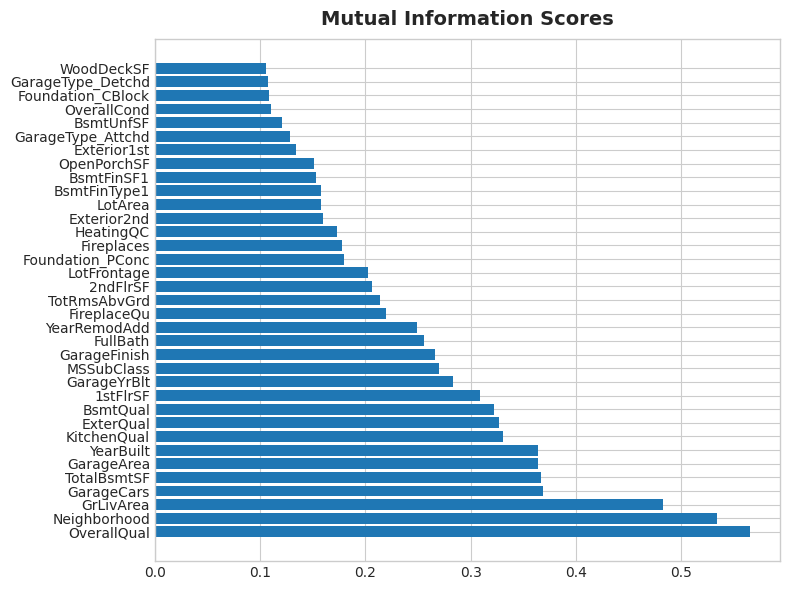

In [14]:
plot_informative(threshold = 0.1)

## 2.3 Drop Uninformative Features

A function which transforms our data by removing features with low mutual information scores:

In [15]:
# X_train must have no NA values
def remove_uninformative(X_train, X_valid, X_test = None, threshold = 1e-5, verbose = False):
    
    # 0. Preprocessing
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. Get discrete columns and target
    discrete = [i for i,x in enumerate(X_train.columns) if x not in numerical]
    y_train = train['SalePrice'].iloc[X_train.index]
    
    # 2. Get mutual information scores
    scores = mutual_info_regression(X_train, y_train, discrete_features = discrete)
    cols = [x for i, x in enumerate(X_train.columns) if scores[i] < threshold]
    
    # 3. Drop the uninformative columns
    X_train.drop(cols, axis = 1, inplace = True)
    X_valid.drop(cols, axis = 1, inplace = True)
    if X_test is not None: X_test.drop(cols, axis = 1, inplace = True)
    
    if verbose:
        print("Dropped columns:", *cols)
    
    return X_train, X_valid, X_test

In [16]:
# Drop uninformative
score = score_xgboost(processing = remove_uninformative)

# Save scores
benchmarks['feature'].append('Mutual_Info')
benchmarks['score'].append(score)


12-Fold Average MAE: 15743.80477 in 72.63s.



# Lesson 3: Creating Features

In this section we create features using static transformations of existing features:

1. Mathematical Transformations
2. Feature Interactions
3. Count Features
4. Building and breaking down features
5. Group transformations


## 3.1 Mathematical Transformations

Create features by combining and/or transforming already existing features

In [17]:
def transformations(input_df, test_data = False):
    
    df = input_df.copy()
    temp = train.iloc[df.index]
    if test_data: temp = test.copy()
        
    df["LivLotRatio"] = temp["GrLivArea"] / temp["LotArea"]
    df["Spaciousness"] = (temp["1stFlrSF"]+temp["2ndFlrSF"]) / temp["TotRmsAbvGrd"]
    df["TotalOutsideSF"] = temp["WoodDeckSF"] + temp["OpenPorchSF"] + temp["EnclosedPorch"] + temp["3SsnPorch"] + temp["ScreenPorch"]
    df['TotalLot'] = temp['LotFrontage'] + temp['LotArea']
    df['TotalBsmtFin'] = temp['BsmtFinSF1'] + temp['BsmtFinSF2']
    df['TotalSF'] = temp['TotalBsmtSF'] + temp['2ndFlrSF'] + temp['1stFlrSF']
    df['TotalBath'] = temp['FullBath'] + temp['HalfBath'] * 0.5 + temp['BsmtFullBath'] + temp['BsmtHalfBath'] * 0.5
    df['TotalPorch'] = temp['OpenPorchSF'] + temp['EnclosedPorch'] + temp['ScreenPorch'] + temp['WoodDeckSF']
    
    return df
    
def mathematical_transformations(X_train, X_valid, X_test = None):
    
    # 0. Preprocessing
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train = transformations(X_train)
    X_valid = transformations(X_valid)
    if X_test is not None: X_test = transformations(X_test)
    
    return X_train, X_valid, X_test

In [18]:
# Mathematical transformations
score = score_xgboost(processing = mathematical_transformations)

# Save scores
benchmarks['feature'].append('Transformations')
benchmarks['score'].append(score)


12-Fold Average MAE: 15508.78515 in 42.56s.



## 3.2 Encode Feature Interactions

Attempt to encode an interaction between a categorical variable and a numerical variable

In [19]:
def interaction(input_df, cat_col = "BldgType", num_col = "GrLivArea"):
    
    df = input_df.copy()
    try:
        # will fail if column already one-hot encoded
        X = pd.get_dummies(df[cat_col], prefix=cat_col)
        for col in X.columns:
            df[col+"_"+num_col] = X[col]*df[num_col]
    except:
        # if column already one-hot encoded
        for col in df.columns:
            if col.startswith(cat_col):
                df[col+"_"+num_col] = df[col]*df[num_col]
    return df

def encode_interaction(X_train, X_valid, X_test = None, cat_col = "BldgType", num_col = "GrLivArea"):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)

    X_train = interaction(X_train, cat_col, num_col)
    X_valid = interaction(X_valid, cat_col, num_col)
    if X_test is not None: X_test = interaction(X_test, cat_col, num_col)
    
    return X_train, X_valid, X_test

In [20]:
# Categorical interactions
score = score_xgboost(processing = encode_interaction)

# Save scores
benchmarks['feature'].append('Interactions')
benchmarks['score'].append(score)


12-Fold Average MAE: 15853.57222 in 43.29s.



## 3.3 Generate a Count Feature

We combine several related features into an aggregate feature counting the presence of the components.

In [21]:
def count_features(X_train, X_valid, X_test = None, features = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"]):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train["PorchTypes"] = X_train[features].gt(0).sum(axis=1)
    X_valid["PorchTypes"] = X_valid[features].gt(0).sum(axis=1)
    if X_test is not None: X_test["PorchTypes"] = X_test[features].gt(0).sum(axis=1)
        
    return X_train, X_valid, X_test

In [22]:
# New count features
score = score_xgboost(processing = count_features)

# Save scores
benchmarks['feature'].append('Count')
benchmarks['score'].append(score)


12-Fold Average MAE: 15755.98938 in 42.38s.



## 3.4 Break Down a Categorical Feature

Note: The column `HouseStyle` already serves the purpose of the `MSClass` feature in the notes, so we create `MSClass` use the `Zoning` column instead:

In [23]:
def breakdown_zoning(X_train, X_valid, X_test = None):
    
    mapping = {'A': 'A','C': 'C',"FV": 'R','I': 'I',"RH": 'R',"RL": 'R',"RP": 'R',"RM": 'R', np.nan:np.nan}
    
    X_train["MSClass"] = train['MSZoning'].iloc[X_train.index].map(mapping)
    X_valid["MSClass"] = train['MSZoning'].iloc[X_valid.index].map(mapping)
    if X_test is not None: X_test["MSClass"] = test['MSZoning'].map(mapping)
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    return X_train, X_valid, X_test

In [24]:
# New count features
score = score_xgboost(processing = breakdown_zoning)

# Save scores
benchmarks['feature'].append('MSZoning')
benchmarks['score'].append(score)


12-Fold Average MAE: 15838.47199 in 44.47s.



## 3.5 Use a Grouped Transform

We create a feature from a statistic calculated on a group. In this case the above ground living area per neighborhood. Note that the statistic is calculated on the training data only.

In [25]:
def group_transformation(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    X_train["MedNhbdLvArea"] = X_train.groupby("Neighborhood")["GrLivArea"].transform('median')
    
    # we use the medians from the training data to impute the test data
    mapping = {y:x for x,y in zip(X_train["MedNhbdLvArea"].values, X_train['Neighborhood'].values)}
    
    X_valid["MedNhbdLvArea"] = X_valid['Neighborhood'].map(mapping)
    if X_test is not None: X_test["MedNhbdLvArea"] = X_test['Neighborhood'].map(mapping)
    
    return X_train, X_valid, X_test

In [26]:
# New count features
score = score_xgboost(processing = group_transformation)

# Save scores
benchmarks['feature'].append('Group')
benchmarks['score'].append(score)


12-Fold Average MAE: 15523.25086 in 40.59s.



# Lesson 4: K-means Clustering

In this section we use unsupervised clustering techniques to build new features for our model.

## 4.1 Cluster Label Features

We create a new feature by clustering a subset of the numerical data and using the resulting cluster labels to create a new categorical feature.

In [27]:
def cluster_labels(X_train, X_valid, X_test = None, name = "Area", features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # 2. create cluster labels (use predict)
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_train[name + "_Cluster"] = kmeans.fit_predict(X_scaled)
    X_valid[name + "_Cluster"] = kmeans.predict(X_valid_scaled)
    if X_test is not None: X_test[name + "_Cluster"] = kmeans.predict(X_test_scaled)
         
    return X_train, X_valid, X_test

In [28]:
# Cluster label features
score = score_xgboost(processing = cluster_labels)

# Save scores
benchmarks['feature'].append('Cluster_Labels')
benchmarks['score'].append(score)


12-Fold Average MAE: 15843.71768 in 128.66s.



## 4.2 Cluster Distance Features

We create new numerical features by clustering a subset of the numerical data and using the distances to each respective cluster centroid.

In [29]:
def cluster_distances(X_train, X_valid, X_test = None, name = "Area", features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # 1. normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # 2. generate cluster distances (use transform)
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    X_valid_cd = kmeans.transform(X_valid_scaled)
    if X_test is not None: X_test_cd = kmeans.transform(X_test_scaled)
    
    # 3. column labels
    X_cd = pd.DataFrame(X_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_cd.shape[1])])
    X_valid_cd = pd.DataFrame(X_valid_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_valid_cd.shape[1])])
    if X_test is not None: X_test_cd = pd.DataFrame(X_test_cd, columns=[name + "_Centroid_" + str(i) for i in range(X_test_cd.shape[1])])    
    
    if X_test is not None:
        return X_train.join(X_cd), X_valid.join(X_valid_cd), X_test.join(X_test_cd)
    
    return X_train.join(X_cd), X_valid.join(X_valid_cd), X_test

In [30]:
# Cluster distance features
score = score_xgboost(processing = cluster_distances)

# Save scores
benchmarks['feature'].append('Cluster_Dist')
benchmarks['score'].append(score)


12-Fold Average MAE: 16114.38487 in 139.65s.



# Lesson 5: Principal Component Analysis

Following the bonus notebook, we use PCA to examine the following four features:  `GarageArea`, `YearRemodAdd`, `TotalBsmtSF`, and `GrLivArea`. 

In [31]:
# Assumes data is standardized
def apply_pca(X):
    
    # Standardize input
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X_scaled.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

## 5.1 Plot Variance

The following function adapted from the notes plots the explained variance and culmulative variance of each component.

In [32]:
def plot_variance(X, width=8, dpi=100):

    pca, _, _ = apply_pca(X)
    
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(-0.1, 1.1)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(-0.1, 1.1)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)

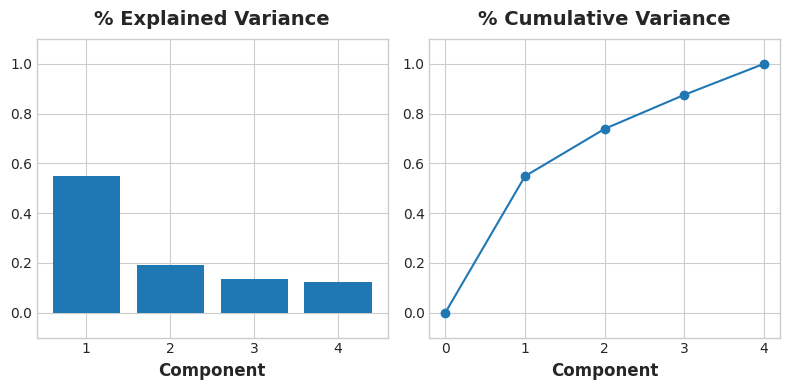

In [33]:
plot_variance(
    train[["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"]]
)

## 5.2 Loadings

View the loadings for each feature/component.

In [34]:
pca, X_pca, loadings = apply_pca(
    train[["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"]]
)
loadings

,PC1,PC2,PC3,PC4
GarageArea,0.542671,0.055849,0.172729,-0.820094
YearRemodAdd,0.418537,-0.883023,-0.052628,0.205735
TotalBsmtSF,0.518308,0.324224,0.617357,0.495082
GrLivArea,0.511558,0.334709,-0.765680,0.200032


## 5.3 Outlier Detection

Find observations with outlier values in each component, this can be useful for finding outlier values that might not be readily apparent in the original feature space:

In [35]:
def check_outliers(X_pca, component = "PC1"):
    idx = X_pca[component].sort_values(ascending=False).index
    return train.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features].head(10)

In [36]:
check_outliers(X_pca, component = "PC1")

,SalePrice,Neighborhood,SaleCondition,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1298,160000,Edwards,Partial,60,RL,313.0,63887,Pave,NaN,IR3,...,0,480,Gd,NaN,NaN,0,1,2008,New,Partial
523,184750,Edwards,Partial,60,RL,130.0,40094,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
1182,745000,NoRidge,Abnorml,60,RL,160.0,15623,Pave,NaN,IR1,...,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
691,755000,NoRidge,Normal,60,RL,104.0,21535,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal
496,430000,NoRidge,Normal,20,RL,NaN,12692,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
581,253293,NridgHt,Partial,20,RL,98.0,12704,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,8,2009,New,Partial
178,501837,StoneBr,Partial,20,RL,63.0,17423,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,7,2009,New,Partial
440,555000,NridgHt,Normal,20,RL,105.0,15431,Pave,NaN,Reg,...,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal
1169,625000,NoRidge,Normal,60,RL,118.0,35760,Pave,NaN,IR1,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
1373,466500,NoRidge,Normal,20,RL,NaN,11400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal


## 5.4 PCA Features

The following function adds the first two principal components as features to our original data:

In [37]:
# Performs PCA on the whole dataframe
def pca_transform(X_train, X_valid, X_test = None, features = ["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea"], n_components = 2):
    
    assert n_components <= len(features)
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    # Normalize based on training data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: X_test_scaled = scaler.transform(X_test[features])
    
    # Create principal components
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)
    X_valid_pca = pca.transform(X_valid_scaled)
    if X_test is not None: X_test_pca = pca.transform(X_test_scaled)
    
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    X_valid_pca = pd.DataFrame(X_valid_pca, columns=component_names)
    if X_test is not None: X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)
    
    if X_test is not None: 
        return X_train.join(X_pca), X_valid.join(X_valid_pca), X_test.join(X_test_pca)

    return X_train.join(X_pca), X_valid.join(X_valid_pca), X_test

In [38]:
# PCA components
score = score_xgboost(processing = pca_transform)

# Save scores
benchmarks['feature'].append('PCA_Comps')
benchmarks['score'].append(score)


12-Fold Average MAE: 16108.08229 in 45.07s.



## 5.5 PCA Inspired Features

Following the bonus notebook, adds two new features inspired by the principal component analysis:

In [39]:
def pca_inspired(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    
    X_train["Feature1"] = X_train.GrLivArea + X_train.TotalBsmtSF
    X_train["Feature2"] = X_train.YearRemodAdd * X_train.TotalBsmtSF
    X_valid["Feature1"] = X_valid.GrLivArea + X_valid.TotalBsmtSF
    X_valid["Feature2"] = X_valid.YearRemodAdd * X_valid.TotalBsmtSF
    if X_test is not None:
        X_test["Feature1"] = X_test.GrLivArea + X_test.TotalBsmtSF
        X_test["Feature2"] = X_test.YearRemodAdd * X_test.TotalBsmtSF
    
    return X_train, X_valid, X_test

In [40]:
# PCA inspired features
score = score_xgboost(processing = pca_inspired)

# Save scores
benchmarks['feature'].append('PCA_Inspired')
benchmarks['score'].append(score)


12-Fold Average MAE: 15575.02949 in 46.89s.



# Lesson 6: Target Encoding

We use the wrapper from the [bonus notebook](https://www.kaggle.com/ryanholbrook/feature-engineering-for-house-prices) to target encode a few categorical variables.

In [41]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

## 6.1 Encode Neighborhood

We use `Neighborhood` to target encode since it is a high cardinality nominal feature which is likely very important for determining the target `SalePrice`.

In [42]:
def encode_neighborhood(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["Neighborhood"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: X1_test = encoder.transform(X_test)
    
    if X_test is not None:
        return X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)

    return X_train.join(X1_train), X_valid.join(X1_valid), X_test

In [43]:
score = score_xgboost(processing = encode_neighborhood)

benchmarks['feature'].append('Encode_Neighborhood')
benchmarks['score'].append(score)


12-Fold Average MAE: 15373.05694 in 43.28s.



## 10.2 Encode Subclass

The example in the notes uses `MSSubClass` for target encoding so we test it out here for sake of completeness.

In [44]:
def encode_subclass(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["MSSubClass"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: X1_test = encoder.transform(X_test)
        
    if X_test is not None:
        return X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)

    return X_train.join(X1_train), X_valid.join(X1_valid), X_test

In [45]:
score = score_xgboost(processing = encode_subclass)

benchmarks['feature'].append('Encode_Subclass')
benchmarks['score'].append(score)


12-Fold Average MAE: 15777.96425 in 43.37s.



# Determining Feature Engineering Strategy

In this section we compare all the above strategies versus the baseline and choose which we will use in our final model.

In [46]:
pd.DataFrame(benchmarks).sort_values('score', ascending = False)

,feature,score
8,Cluster_Dist,16114.384871
9,PCA_Comps,16108.082289
3,Interactions,15853.572220
7,Cluster_Labels,15843.717681
0,Baseline,15838.471986
5,MSZoning,15838.471986
12,Encode_Subclass,15777.964251
4,Count,15755.989377
1,Mutual_Info,15743.804768
10,PCA_Inspired,15575.029491


## Final Feature Engineering

We include all of the techniques which resulted in improvements over the baseline.

In [47]:
def feature_engineering(X_train, X_valid, X_test = None):
    
    X_train, X_valid, X_test = preprocessing(X_train, X_valid, X_test)
    y_train = train['SalePrice'].iloc[X_train.index]
    og_columns = [x for x in X_train.columns]
    
    # Drop the uninformative columns
    discrete = [i for i,x in enumerate(X_train.columns) if x not in numerical]
    scores = mutual_info_regression(X_train, y_train, discrete_features = discrete)
    cols = [x for i, x in enumerate(X_train.columns) if scores[i] < 1e-5]
    X_train.drop(cols, axis = 1, inplace = True)
    X_valid.drop(cols, axis = 1, inplace = True)
    if X_test is not None: 
        X_test.drop(cols, axis = 1, inplace = True)
    
    # Cluster Labels
    features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])
    if X_test is not None: 
        X_test_scaled = scaler.transform(X_test[features])
    kmeans = KMeans(n_clusters = 10, n_init = 10, random_state=0)
    X_train["Cluster"] = kmeans.fit_predict(X_scaled)
    X_valid["Cluster"] = kmeans.predict(X_valid_scaled)
    if X_test is not None: 
        X_test["Cluster"] = kmeans.predict(X_test_scaled)
    
    # Group Transformation
    X_train["MedNhbdLvArea"] = X_train.groupby("Neighborhood")["GrLivArea"].transform('median')
    mapping = {y:x for x,y in zip(X_train["MedNhbdLvArea"].values, X_train['Neighborhood'].values)}
    X_valid["MedNhbdLvArea"] = X_valid['Neighborhood'].map(mapping)
    if X_test is not None: 
        X_test["MedNhbdLvArea"] = X_test['Neighborhood'].map(mapping)
    
    # PCA Inspired
    X_train["Feature1"] = X_train.GrLivArea + X_train.TotalBsmtSF
    X_train["Feature2"] = X_train.YearRemodAdd * X_train.TotalBsmtSF
    X_valid["Feature1"] = X_valid.GrLivArea + X_valid.TotalBsmtSF
    X_valid["Feature2"] = X_valid.YearRemodAdd * X_valid.TotalBsmtSF
    if X_test is not None:
        X_test["Feature1"] = X_test.GrLivArea + X_test.TotalBsmtSF
        X_test["Feature2"] = X_test.YearRemodAdd * X_test.TotalBsmtSF
    
    # Transformations
    X_train = transformations(X_train)
    X_valid = transformations(X_valid)
    if X_test is not None: 
        X_test = transformations(X_test, test_data = True)
        
    
    # Target Encode Subclass
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X1_train = encoder.fit_transform(X_train, y_train, cols=["MSSubClass"])
    X1_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X1_test = encoder.transform(X_test)
        
    if X_test is not None:
        X_train, X_valid, X_test = X_train.join(X1_train), X_valid.join(X1_valid), X_test.join(X1_test)
    else:
        X_train, X_valid = X_train.join(X1_train), X_valid.join(X1_valid)
        
    # Target Encode Neighborhood
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X2_train = encoder.fit_transform(X_train, y_train, cols=["Neighborhood"])
    X2_valid = encoder.transform(X_valid)
    if X_test is not None: 
        X2_test = encoder.transform(X_test)
        
    if X_test is not None:
        return X_train.join(X2_train), X_valid.join(X2_valid), X_test.join(X2_test)

    return X_train.join(X2_train), X_valid.join(X2_valid), X_test

In [48]:
_ = score_xgboost(processing = feature_engineering)


12-Fold Average MAE: 15580.38715 in 167.4s.



# Hyperparameter Search

Now that we have established our preprocessing and feature engineering strategies we want to optimize our model parameters.

## Pruning

We use a pruner to skip unpromising trials (in the lower 33% of scores for that fold).

In [49]:
# Tweak Pruner settings
pruner = PercentilePruner(
    percentile = 33,
    n_startup_trials = 10,
    n_warmup_steps = 0,
    interval_steps = 1,
    n_min_trials = 10,
)

## Search Function

Function which actually performs the hyperparameter search, based on [optuna](https://optuna.org/):

In [50]:
def parameter_search(trials):
    
    # Optuna objective function
    def objective(trial):
        
        model_params = dict( 
            # default 6
            max_depth = trial.suggest_int(
                "max_depth", 2, 12
            ), 
            # default 0.3
            learning_rate = trial.suggest_loguniform(
                "learning_rate", 0.01, 0.3
            ),
            # default 0
            gamma = trial.suggest_loguniform(
                "gamma", 1e-10, 100
            ), 
            # default 1
            min_child_weight = trial.suggest_loguniform(
                "min_child_weight", 1e-2, 1e2
            ),
            # default 1
            subsample = trial.suggest_discrete_uniform(
                "subsample", 0.2, 1.0, 0.01
            ),
            # default 1
            colsample_bytree = trial.suggest_discrete_uniform(
                "colsample_bytree",  0.2, 1.0, 0.01
            ),
            # default 1
            colsample_bylevel = trial.suggest_discrete_uniform(
                "colsample_bylevel",  0.2, 1.0, 0.01
            ),
            # default 1
            reg_lambda = trial.suggest_loguniform(
                "reg_lambda", 1e-10, 100
            ),
            # default 0
            reg_alpha = trial.suggest_loguniform(
                "reg_alpha", 1e-10, 100
            ),
        )
        
        return score_xgboost(
            xgb_model = XGBRegressor(
                random_state = RANDOM_SEED, 
                n_estimators = MAX_TREES,
                n_jobs = 4,
                **model_params
            ),
            processing = feature_engineering,
            trial = trial
        )
    
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(
        pruner = pruner,
        direction = "minimize"
    )
    # close to default parameters
    study.enqueue_trial({
        'max_depth': 6, 
        'learning_rate': 0.05, 
        'gamma': 1e-10,
        'min_child_weight': 1, 
        'subsample': 1, 
        'colsample_bytree': 1, 
        'colsample_bylevel': 1,
        'reg_lambda': 1,
        'reg_alpha': 1,
    })
    study.optimize(objective, n_trials=trials)
    return study

## Hyperparameter Evaluation

In [51]:
study = parameter_search(NUM_TRIALS)

[I 2022-01-07 07:38:53,351] A new study created in memory with name: no-name-57342444-18ae-43e5-b736-8bfa1658865d
[D 2022-01-07 07:38:53,353] Trial 0 popped from the trial queue.
[I 2022-01-07 07:41:47,042] Trial 0 finished with value: 15494.698595492931 and parameters: {'max_depth': 6, 'learning_rate': 0.05, 'gamma': 1e-10, 'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'reg_lambda': 1, 'reg_alpha': 1}. Best is trial 0 with value: 15494.698595492931.



12-Fold Average MAE: 15494.6986 in 167.65s.



[I 2022-01-07 07:44:20,741] Trial 1 finished with value: 14934.235838256058 and parameters: {'max_depth': 3, 'learning_rate': 0.0436770719162875, 'gamma': 1.954230063243163e-08, 'min_child_weight': 0.18222102982460525, 'subsample': 0.98, 'colsample_bytree': 0.95, 'colsample_bylevel': 0.53, 'reg_lambda': 0.013391897642722188, 'reg_alpha': 10.560919687358192}. Best is trial 1 with value: 14934.235838256058.



12-Fold Average MAE: 14934.23584 in 147.66s.



[I 2022-01-07 07:46:54,752] Trial 2 finished with value: 14395.994608200106 and parameters: {'max_depth': 5, 'learning_rate': 0.04762798327723412, 'gamma': 9.44813910066458e-09, 'min_child_weight': 4.132483973259069, 'subsample': 1.0, 'colsample_bytree': 0.28, 'colsample_bylevel': 0.7, 'reg_lambda': 0.0008186123843645678, 'reg_alpha': 84.90853733532806}. Best is trial 2 with value: 14395.994608200106.



12-Fold Average MAE: 14395.99461 in 147.97s.



[I 2022-01-07 07:49:33,839] Trial 3 finished with value: 14073.809988889689 and parameters: {'max_depth': 4, 'learning_rate': 0.024619491074314343, 'gamma': 0.48030764429429823, 'min_child_weight': 0.0849500756296301, 'subsample': 0.43000000000000005, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.53, 'reg_lambda': 5.985085150239527e-09, 'reg_alpha': 7.695419053419752e-09}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 14073.80999 in 153.04s.



[I 2022-01-07 07:52:06,938] Trial 4 finished with value: 15868.894409350587 and parameters: {'max_depth': 5, 'learning_rate': 0.13019121998062166, 'gamma': 8.744224384151995e-06, 'min_child_weight': 9.097472460744461, 'subsample': 0.98, 'colsample_bytree': 0.8300000000000001, 'colsample_bylevel': 0.66, 'reg_lambda': 2.219148830836188e-06, 'reg_alpha': 9.517730984136664e-09}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 15868.89441 in 147.05s.



[I 2022-01-07 07:54:34,538] Trial 5 finished with value: 15681.850478371409 and parameters: {'max_depth': 11, 'learning_rate': 0.14530864720566256, 'gamma': 1.7860653058936007e-07, 'min_child_weight': 15.807669766352278, 'subsample': 0.66, 'colsample_bytree': 0.8600000000000001, 'colsample_bylevel': 0.34, 'reg_lambda': 0.03388363151979098, 'reg_alpha': 0.00020986398857949788}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 15681.85048 in 141.55s.



[I 2022-01-07 07:57:02,072] Trial 6 finished with value: 18796.57473902764 and parameters: {'max_depth': 11, 'learning_rate': 0.2537400143230779, 'gamma': 0.007912019446535433, 'min_child_weight': 0.028621981268003412, 'subsample': 0.72, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.47000000000000003, 'reg_lambda': 0.029705724812803005, 'reg_alpha': 5.367532499627406e-07}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 18796.57474 in 141.49s.



[I 2022-01-07 07:59:35,353] Trial 7 finished with value: 16391.25255794721 and parameters: {'max_depth': 2, 'learning_rate': 0.03160020819810876, 'gamma': 45.522783528566144, 'min_child_weight': 2.4266299735202552, 'subsample': 0.44, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.22, 'reg_lambda': 0.0012454753127191106, 'reg_alpha': 2.535529940282492}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 16391.25256 in 147.24s.



[I 2022-01-07 08:02:15,731] Trial 8 finished with value: 16119.99452570631 and parameters: {'max_depth': 11, 'learning_rate': 0.13421630929542255, 'gamma': 7.902745331878208e-05, 'min_child_weight': 0.010845007784197204, 'subsample': 0.42000000000000004, 'colsample_bytree': 0.65, 'colsample_bylevel': 0.45, 'reg_lambda': 11.120878885237293, 'reg_alpha': 1.567698602864263e-07}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 16119.99453 in 154.33s.



[I 2022-01-07 08:04:40,835] Trial 9 finished with value: 15356.07662240448 and parameters: {'max_depth': 10, 'learning_rate': 0.08671978513187163, 'gamma': 0.00010836103196833708, 'min_child_weight': 12.51211056967479, 'subsample': 0.29000000000000004, 'colsample_bytree': 0.45, 'colsample_bylevel': 0.4, 'reg_lambda': 2.138336609327933e-09, 'reg_alpha': 0.011177575017431517}. Best is trial 3 with value: 14073.809988889689.



12-Fold Average MAE: 15356.07662 in 139.06s.



[I 2022-01-07 08:04:53,509] Trial 10 pruned. 
[I 2022-01-07 08:07:39,097] Trial 11 finished with value: 14017.469791790152 and parameters: {'max_depth': 4, 'learning_rate': 0.018351164067120396, 'gamma': 0.10572612593086676, 'min_child_weight': 0.571962778979969, 'subsample': 0.8, 'colsample_bytree': 0.21000000000000002, 'colsample_bylevel': 0.69, 'reg_lambda': 1.2636666013074263e-06, 'reg_alpha': 1.8326429501350608e-10}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14017.46979 in 159.51s.



[I 2022-01-07 08:07:50,608] Trial 12 pruned. 
[I 2022-01-07 08:08:01,708] Trial 13 pruned. 
[I 2022-01-07 08:11:50,862] Trial 14 finished with value: 15155.724532460174 and parameters: {'max_depth': 8, 'learning_rate': 0.012276323825239287, 'gamma': 0.10072462004329692, 'min_child_weight': 0.5959326769069762, 'subsample': 0.8300000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8900000000000001, 'reg_lambda': 1.278618965883176e-05, 'reg_alpha': 2.6356060573642556e-06}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 15155.72453 in 223.07s.



[I 2022-01-07 08:12:02,620] Trial 15 pruned. 
[I 2022-01-07 08:12:13,819] Trial 16 pruned. 
[I 2022-01-07 08:12:25,896] Trial 17 pruned. 
[I 2022-01-07 08:16:09,850] Trial 18 finished with value: 14718.73801345939 and parameters: {'max_depth': 6, 'learning_rate': 0.010130617172570957, 'gamma': 4.1207514459611305, 'min_child_weight': 2.1760876553010893, 'subsample': 0.8800000000000001, 'colsample_bytree': 0.75, 'colsample_bylevel': 0.8400000000000001, 'reg_lambda': 1.1135552606514519e-05, 'reg_alpha': 6.206790912010399e-08}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14718.73801 in 217.87s.



[I 2022-01-07 08:16:21,058] Trial 19 pruned. 
[I 2022-01-07 08:16:32,597] Trial 20 pruned. 
[I 2022-01-07 08:17:00,202] Trial 21 pruned. 
[I 2022-01-07 08:17:11,175] Trial 22 pruned. 
[I 2022-01-07 08:17:36,493] Trial 23 pruned. 
[I 2022-01-07 08:17:47,914] Trial 24 pruned. 
[I 2022-01-07 08:17:58,948] Trial 25 pruned. 
[I 2022-01-07 08:18:11,288] Trial 26 pruned. 
[I 2022-01-07 08:18:22,745] Trial 27 pruned. 
[I 2022-01-07 08:18:47,450] Trial 28 pruned. 
[I 2022-01-07 08:18:58,439] Trial 29 pruned. 
[I 2022-01-07 08:19:10,268] Trial 30 pruned. 
[I 2022-01-07 08:22:41,247] Trial 31 finished with value: 14822.644584812535 and parameters: {'max_depth': 6, 'learning_rate': 0.010282045991490667, 'gamma': 6.496122269042078, 'min_child_weight': 1.698817048454, 'subsample': 0.9099999999999999, 'colsample_bytree': 0.73, 'colsample_bylevel': 0.8300000000000001, 'reg_lambda': 2.0286520745326785e-05, 'reg_alpha': 4.109285948997077e-08}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14822.64458 in 204.89s.



[I 2022-01-07 08:22:53,230] Trial 32 pruned. 
[I 2022-01-07 08:23:05,516] Trial 33 pruned. 
[I 2022-01-07 08:23:16,517] Trial 34 pruned. 
[I 2022-01-07 08:23:40,543] Trial 35 pruned. 
[I 2022-01-07 08:23:52,191] Trial 36 pruned. 
[I 2022-01-07 08:24:04,812] Trial 37 pruned. 
[I 2022-01-07 08:24:15,754] Trial 38 pruned. 
[I 2022-01-07 08:24:28,234] Trial 39 pruned. 
[I 2022-01-07 08:24:39,603] Trial 40 pruned. 
[I 2022-01-07 08:28:08,644] Trial 41 finished with value: 14785.06124298946 and parameters: {'max_depth': 6, 'learning_rate': 0.010205525547670019, 'gamma': 12.16907351174688, 'min_child_weight': 1.8840824573623736, 'subsample': 0.9199999999999999, 'colsample_bytree': 0.73, 'colsample_bylevel': 0.8400000000000001, 'reg_lambda': 2.243228293788579e-05, 'reg_alpha': 2.5329736402697768e-08}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14785.06124 in 202.95s.



[I 2022-01-07 08:28:21,180] Trial 42 pruned. 
[I 2022-01-07 08:28:32,524] Trial 43 pruned. 
[I 2022-01-07 08:28:44,773] Trial 44 pruned. 
[I 2022-01-07 08:28:55,691] Trial 45 pruned. 
[I 2022-01-07 08:29:10,153] Trial 46 pruned. 
[I 2022-01-07 08:29:21,415] Trial 47 pruned. 
[I 2022-01-07 08:29:32,455] Trial 48 pruned. 
[I 2022-01-07 08:29:56,105] Trial 49 pruned. 
[I 2022-01-07 08:30:07,372] Trial 50 pruned. 
[I 2022-01-07 08:30:19,961] Trial 51 pruned. 
[I 2022-01-07 08:30:52,574] Trial 52 pruned. 
[I 2022-01-07 08:31:04,508] Trial 53 pruned. 
[I 2022-01-07 08:34:51,015] Trial 54 finished with value: 15090.635457285103 and parameters: {'max_depth': 7, 'learning_rate': 0.010115979470056284, 'gamma': 2.0749401245982715, 'min_child_weight': 1.195311041168914, 'subsample': 0.9099999999999999, 'colsample_bytree': 0.6100000000000001, 'colsample_bylevel': 0.8900000000000001, 'reg_lambda': 5.4926501940490584e-05, 'reg_alpha': 4.880061149918582e-08}. Best is trial 11 with value: 14017.4697917


12-Fold Average MAE: 15090.63546 in 220.42s.



[I 2022-01-07 08:37:40,492] Trial 55 finished with value: 14262.638825638498 and parameters: {'max_depth': 6, 'learning_rate': 0.020772030014590367, 'gamma': 8.617675906618029, 'min_child_weight': 0.4380873788017646, 'subsample': 0.78, 'colsample_bytree': 0.25, 'colsample_bylevel': 0.75, 'reg_lambda': 0.000403625478420368, 'reg_alpha': 1.5277176154610506e-10}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14262.63883 in 163.39s.



[I 2022-01-07 08:37:52,004] Trial 56 pruned. 
[I 2022-01-07 08:38:02,693] Trial 57 pruned. 
[I 2022-01-07 08:38:28,535] Trial 58 pruned. 
[I 2022-01-07 08:38:40,076] Trial 59 pruned. 
[I 2022-01-07 08:38:51,633] Trial 60 pruned. 
[I 2022-01-07 08:39:03,762] Trial 61 pruned. 
[I 2022-01-07 08:39:16,528] Trial 62 pruned. 
[I 2022-01-07 08:39:27,906] Trial 63 pruned. 
[I 2022-01-07 08:39:41,163] Trial 64 pruned. 
[I 2022-01-07 08:42:21,767] Trial 65 finished with value: 14866.371041907463 and parameters: {'max_depth': 7, 'learning_rate': 0.055976537305835, 'gamma': 50.560634670627664, 'min_child_weight': 0.2869108137543308, 'subsample': 0.79, 'colsample_bytree': 0.53, 'colsample_bylevel': 0.81, 'reg_lambda': 2.1216674275759756e-07, 'reg_alpha': 8.885733597688013e-08}. Best is trial 11 with value: 14017.469791790152.



12-Fold Average MAE: 14866.37104 in 154.51s.



[I 2022-01-07 08:45:26,831] Trial 66 finished with value: 13969.718847598917 and parameters: {'max_depth': 5, 'learning_rate': 0.011696406936555409, 'gamma': 12.807660115197367, 'min_child_weight': 1.4060530724511293, 'subsample': 0.65, 'colsample_bytree': 0.21000000000000002, 'colsample_bylevel': 0.9199999999999999, 'reg_lambda': 0.0002610709101962165, 'reg_alpha': 7.726969710219861}. Best is trial 66 with value: 13969.718847598917.



12-Fold Average MAE: 13969.71885 in 178.98s.



[I 2022-01-07 08:45:37,921] Trial 67 pruned. 
[I 2022-01-07 08:45:49,596] Trial 68 pruned. 
[I 2022-01-07 08:46:17,321] Trial 69 pruned. 
[I 2022-01-07 08:46:28,810] Trial 70 pruned. 
[I 2022-01-07 08:46:58,687] Trial 71 pruned. 
[I 2022-01-07 08:47:11,191] Trial 72 pruned. 
[I 2022-01-07 08:47:23,960] Trial 73 pruned. 
[I 2022-01-07 08:47:36,257] Trial 74 pruned. 
[I 2022-01-07 08:47:49,507] Trial 75 pruned. 
[I 2022-01-07 08:48:01,075] Trial 76 pruned. 
[I 2022-01-07 08:48:12,803] Trial 77 pruned. 
[I 2022-01-07 08:48:24,517] Trial 78 pruned. 
[I 2022-01-07 08:48:36,305] Trial 79 pruned. 
[I 2022-01-07 08:48:47,933] Trial 80 pruned. 
[I 2022-01-07 08:48:59,437] Trial 81 pruned. 
[I 2022-01-07 08:49:10,541] Trial 82 pruned. 
[I 2022-01-07 08:49:21,543] Trial 83 pruned. 
[I 2022-01-07 08:49:33,056] Trial 84 pruned. 
[I 2022-01-07 08:49:44,495] Trial 85 pruned. 
[I 2022-01-07 08:49:57,233] Trial 86 pruned. 
[I 2022-01-07 08:50:08,674] Trial 87 pruned. 
[I 2022-01-07 08:50:32,901] Trial 

In [52]:
print("Best Parameters:", study.best_params)

Best Parameters: {'max_depth': 5, 'learning_rate': 0.011696406936555409, 'gamma': 12.807660115197367, 'min_child_weight': 1.4060530724511293, 'subsample': 0.65, 'colsample_bytree': 0.21000000000000002, 'colsample_bylevel': 0.9199999999999999, 'reg_lambda': 0.0002610709101962165, 'reg_alpha': 7.726969710219861}


In [53]:
plot_parallel_coordinate(study)

# Generate Submission

In [54]:
def make_submission(model_params):
    
    # Features
    features = [x for x in train.columns if x not in ['Id','SalePrice']]
    X_temp = train[features].copy()
    y_temp = train['SalePrice'].copy()
    
    # Data structure for storing scores and times
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_temp, y_bins)):
        
        # Training and Validation Sets
        X_train, X_valid = X_temp.iloc[train_idx], X_temp.iloc[valid_idx]
        y_train, y_valid = y_temp.iloc[train_idx], y_temp.iloc[valid_idx]
        X_test = test[features].copy()
        
        # Preprocessing
        X_train, X_valid, X_test = feature_engineering(X_train, X_valid, X_test)
        
        # Create model
        start = time.time()
        model = XGBRegressor(
            random_state = RANDOM_SEED, 
            n_estimators = MAX_TREES,
            n_jobs = 4,
            **model_params
        )
        model.fit(
            X_train, y_train, 
            early_stopping_rounds=EARLY_STOP,
            eval_set=[(X_valid, y_valid)], 
            verbose=False
        )
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict(X_test) / NUM_FOLDS
        scores[fold] = mean_absolute_error(y_valid, valid_preds)
        end = time.time()
        times[fold] = end - start
        print(f'Fold {fold} MAE: {round(scores[fold], 5)} in {round(end-start,2)}s.')
        time.sleep(0.5)
        
    print(f'\n{NUM_FOLDS}-Fold Average MAE: {round(scores.mean(), 5)} in {round(times.sum(),2)}s.')

    output = pd.DataFrame({'Id': test.Id,'SalePrice': test_preds})
    output.to_csv('new_submission.csv', index=False)

In [55]:
# Make final submission
make_submission(study.best_params)

Fold 0 MAE: 17036.57345 in 6.13s.
Fold 1 MAE: 10517.46299 in 4.47s.
Fold 2 MAE: 13275.18897 in 4.19s.
Fold 3 MAE: 13847.10102 in 4.05s.
Fold 4 MAE: 13120.46958 in 3.72s.
Fold 5 MAE: 15351.65154 in 3.45s.
Fold 6 MAE: 14933.21933 in 4.42s.
Fold 7 MAE: 11838.48092 in 5.59s.
Fold 8 MAE: 13737.39834 in 4.68s.
Fold 9 MAE: 15418.44909 in 3.46s.
Fold 10 MAE: 14154.5011 in 3.7s.
Fold 11 MAE: 13662.08807 in 4.79s.

12-Fold Average MAE: 13907.71537 in 52.64s.


Thanks for reading, I hope you found this useful!